# Inside Airbnb 2022 (4 Jan 2022)

### Importing Packages
**Here, I am taking the main packages from throughout the practicals as well as some of the functions from FSDS**

Work breakdown:
* Matthew Martignoni: Cleaning and NLP

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [3]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [4]:
# This is the Plotting Function Jon wrote
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [5]:
#This is used in NLP to convert string object to be compatible with markdown
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

### Reading in the Data

In [6]:
listings2022 = pd.read_csv('listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {listings2022.shape[0]:,} x {listings2022.shape[1]}")

Data frame is 69,351 x 75


In [7]:
# adding the borough data for maps
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


### General Data Cleaning: Booleans, Dates, Categories, Price Strings, Geography
**Most of this code comes from practical 5**

**In this section, I clean the entire dataset before selecting specific columns. This is for the purpose of reproducibility; individuals can select other fields in the Inside Airbnb dataset to expand upon this analysis.**


In [8]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

#### Booleans

In [9]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [10]:
# Here I want to find which columsn have t/f as a value and should be booleans, check how to do this because I just went into the excel doc
#listings2022.filter(regex=("t"))

In [11]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
for b in bcols:
    print(f"Converting {b}")
    listings2022[b] = listings2022[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [12]:
print(listings2022.has_availability.dtype)
#all seem to be booleans but idk why that didn't improve the memory

bool


In [13]:
shm = listings2022.host_is_superhost.memory_usage(deep=True) # Super Host Memory
bhm = listings2022.host_is_superhost.replace({'f':False, 't':True}).astype('bool').memory_usage(deep=True) # Boolean Host Memory

print(f"The raw memory usage of `host_is_superhost` is {shm/1000:,.0f} Kb.")
print(f"The boolean memory usage of `host_is_superhost` is {bhm/1000:,.0f} Kb.")
print(f"That's {(bhm/shm)*100:.0f}% of the original!")

The raw memory usage of `host_is_superhost` is 69 Kb.
The boolean memory usage of `host_is_superhost` is 69 Kb.
That's 100% of the original!


In [14]:
listings2022.sample(5, random_state=43)[bcols]

,instant_bookable,host_has_profile_pic,host_identity_verified,host_is_superhost,has_availability
17512,True,True,True,False,True
51224,False,True,True,False,True
788,False,True,False,False,True
24782,True,True,True,False,True
18992,False,True,True,False,True


#### Dates

In [15]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']
listings2022.sample(5, random_state=43)[dates]

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
17512,2022-09-11,2014-04-29,2022-09-11,2017-07-01,2017-09-05
51224,2022-09-11,2015-05-21,2022-09-11,2021-11-12,2021-11-12
788,2022-09-11,2012-07-13,2022-09-11,NaN,NaN
24782,2022-09-11,2015-09-04,2022-09-11,2018-06-02,2022-07-04
18992,2022-09-11,2014-06-08,2022-09-11,2017-08-17,2022-08-17


In [16]:
for d in dates:
    print("Converting " + d)
    listings2022[d] = pd.to_datetime(listings2022[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [17]:
# This checks that we successfully changed the dates for each
for d in dates:
    print(listings2022[d].dtype, "\n")
    print(listings2022.sample(5, random_state=45)[d].dt.strftime('%A %B %d, %Y'))

datetime64[ns] 

10125    Sunday September 11, 2022
61320    Sunday September 11, 2022
49096    Monday September 12, 2022
36687    Monday September 12, 2022
6747     Sunday September 11, 2022
Name: last_scraped, dtype: object
datetime64[ns] 

10125         Monday March 11, 2013
61320     Tuesday November 17, 2009
49096          Tuesday May 03, 2016
36687    Tuesday September 06, 2016
6747      Wednesday August 12, 2015
Name: host_since, dtype: object
datetime64[ns] 

10125    Sunday September 11, 2022
61320    Sunday September 11, 2022
49096    Monday September 12, 2022
36687    Monday September 12, 2022
6747     Sunday September 11, 2022
Name: calendar_last_scraped, dtype: object
datetime64[ns] 

10125    Wednesday November 23, 2016
61320                            NaN
49096           Sunday July 04, 2021
36687         Saturday July 06, 2019
6747                             NaN
Name: first_review, dtype: object
datetime64[ns] 

10125    Tuesday September 06, 2022
61320                

#### Categories

In [18]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']
listings2022.sample(5, random_state=42)[cats]

,property_type,room_type,host_location,host_response_time,host_location,neighbourhood_cleansed
26643,Private room in rental unit,Private room,"London, United Kingdom",NaN,"London, United Kingdom",Tower Hamlets
15713,Entire rental unit,Entire home/apt,"London, United Kingdom",within an hour,"London, United Kingdom",Westminster
67606,Entire home,Entire home/apt,"London, United Kingdom",NaN,"London, United Kingdom",Croydon
40703,Entire rental unit,Entire home/apt,"England, United Kingdom",NaN,"England, United Kingdom",Kensington and Chelsea
625,Entire rental unit,Entire home/apt,"London, United Kingdom",NaN,"London, United Kingdom",Kensington and Chelsea


In [19]:
listings2022[cats[0]].value_counts()

Entire rental unit             22780
Private room in rental unit    12133
Entire condo                    8676
Private room in home            8500
Entire home                     5379
                               ...  
Shared room in earthen home        1
Shared room in villa               1
Yurt                               1
Shared room in bus                 1
Bus                                1
Name: property_type, Length: 100, dtype: int64

In [20]:
for c in cats:
    print(f"Converting {c}")
    listings2022[c] = listings2022[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


In [21]:
print(listings2022[cats[3]].cat.categories.values)

['a few days or more' 'within a day' 'within a few hours' 'within an hour']


#### Price and String Values

In [22]:
money = ['price']
listings2022.sample(10, random_state=42)[money]

,price
26643,$22.00
15713,$450.00
67606,$175.00
40703,$214.00
625,$50.00
21460,$80.00
16731,$125.00
60779,$154.00
6370,$45.00
48603,$145.00


In [23]:
for m in money:
    print(f"Converting {m}")
    listings2022[m] = listings2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')
# part of the issue here was that you had to remove the commas as well because it wouldn't convert to a float if you just removed the $

Converting price


In [24]:
print(listings2022.price.dtype)

float64


In [25]:
print(len(listings2022[listings2022['price'] == 0]))

19


In [26]:
listings2022.price.describe()

count   69,351.00
mean       177.21
std        412.82
min          0.00
25%         55.00
50%        100.00
75%        180.00
max     25,000.00
Name: price, dtype: float64

Text(0, 0.5, 'Listing Count')

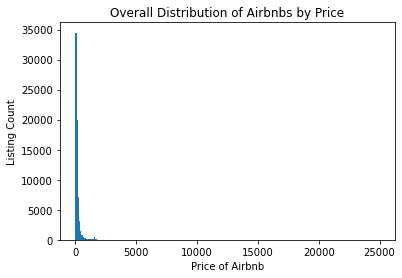

In [ ]:
#Histograms of all Price data to help us see the mean
listings2022.price.plot.hist(bins=250)
plt.title("Overall Distribution of Airbnbs by Price")
plt.xlabel('Price of Airbnb')
plt.ylabel('Listing Count')

Text(0, 0.5, 'Listing Count')

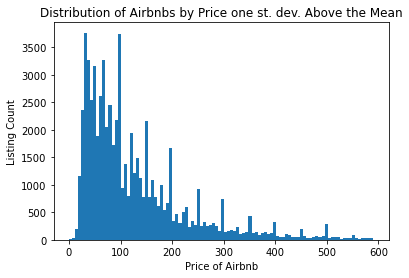

In [50]:
#Histogram of data 1 standard deviations above the mean
#listings2022_std = listings2022.price.drop(thresh=(177.21+(2*412.82)))
listings2022_std = listings2022[listings2022['price'] < (177.21+412.82)]


listings2022_std.price.plot.hist(bins= 100)
plt.title("Distribution of Airbnbs by Price one st. dev. Above the Mean")
plt.xlabel('Price of Airbnb')
plt.ylabel('Listing Count')

#### Converting other Values to Pandas Integers

In [51]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        listings2022[i] = listings2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        listings2022[i] = listings2022[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


#### Making the Longitude and Latitude in Geographically Usable Data

In [52]:
geo_listings2022 = gpd.GeoDataFrame(listings2022,geometry=gpd.points_from_xy(listings2022 .longitude, listings2022 .latitude, crs='epsg:4326'))
geo_listings2022.to_crs('epsg:27700')

#check the type
print(type(geo_listings2022))
print(type(geo_listings2022.geometry))
geo_listings2022.price.head

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


<bound method NDFrame.head of 0        50.00
1        75.00
2        90.00
3        55.00
4       379.00
         ...  
69346    55.00
69347   201.00
69348   246.00
69349   250.00
69350   134.00
Name: price, Length: 69351, dtype: float64>

#### Exporting cleaned file

**This comes from practical 5 too. Undo the commenting out if you want to save these listings. The files are large and won't upload to github.

In [35]:
# Save general cleaned data
#listings2022.to_csv('2022listingsclean.csv')

In [36]:
# Save spatial cleaned data
#geo_listings2022.to_csv('geo_2022listingsclean.csv')

### NaNs and Nulls
**Here is potential code to identify null values in the whole dataset. However, we will not clean the null values yet because determining what to drop depends on the fields you intend to use for analysis.**

In [41]:
listings2022.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            69351 non-null  int64         
 1   listing_url                                   69351 non-null  object        
 2   scrape_id                                     69351 non-null  int64         
 3   last_scraped                                  69351 non-null  datetime64[ns]
 4   source                                        69351 non-null  object        
 5   name                                          69330 non-null  object        
 6   description                                   67832 non-null  object        
 7   neighborhood_overview                         39964 non-null  object        
 8   picture_url                                   69351 non-null  obje

In [42]:
#check for columns with most na values but here I will sort them in descending order to get a better visual sense
listings2022.isna().sum().sort_values(ascending=False).head(45)

calendar_updated                               69351
bathrooms                                      69351
neighbourhood_group_cleansed                   69351
license                                        69351
host_about                                     32405
neighborhood_overview                          29387
neighbourhood                                  29386
host_response_rate                             26521
host_response_time                             26521
host_neighbourhood                             25754
host_acceptance_rate                           24261
review_scores_value                            17837
review_scores_checkin                          17836
review_scores_location                         17834
review_scores_communication                    17803
review_scores_accuracy                         17802
review_scores_cleanliness                      17789
review_scores_rating                           16780
last_review                                   

In [43]:
#drop listings with na ID values (this is more for the process because there don't appear to be any with no ID)
listings2022.drop(listings2022[listings2022.id.isna()].index.array, axis=0, inplace=True)

In [44]:
#count the null values by the row
listings2022.isnull().sum(axis=1).sort_values(ascending=False).head(20)

4511     28
6365     28
7415     28
5697     28
46088    27
45985    27
42836    26
6959     26
43316    25
43100    25
43617    25
43974    25
42704    25
27438    24
46943    24
41873    24
42068    24
34516    24
33792    24
41178    24
dtype: int64

### Focused Cleaning
**These are the columns we will use for our purposes and so we will drop the null values accordingly**
cols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'rom_type','price', 'accomodates' 'minimum_nights', 'maximum_nights']

In [54]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type','price', 'minimum_nights', 'maximum_nights', 'geometry']
geo_listings2022_cleaned = geo_listings2022[fcols]

In [55]:
geo_listings2022_cleaned.head(5)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, United Kingdom",3,4,Islington,51.57,-0.11,Private room in rental unit,Private room,50.00,1,29,POINT (-0.11270 51.56861)
1,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,"Kensington, United Kingdom",1,12,Kensington and Chelsea,51.49,-0.17,Entire rental unit,Entire home/apt,75.00,3,50,POINT (-0.16813 51.48780)
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,"London, United Kingdom",1,3,Tower Hamlets,51.53,-0.07,Entire rental unit,Entire home/apt,90.00,5,365,POINT (-0.07426 51.52851)
3,106332,"Lovely large room, Bethnal Green",Lovely characterful room in a house belonging ...,264345,"London, United Kingdom",2,5,Tower Hamlets,51.53,-0.05,Private room in home,Private room,55.00,3,365,POINT (-0.05396 51.52874)
4,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,67564,"London, United Kingdom",6,32,Westminster,51.52,-0.14,Entire rental unit,Entire home/apt,379.00,4,365,POINT (-0.14094 51.52195)


In [56]:
geo_listings2022_cleaned.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         69351 non-null  int64   
 1   name                       69330 non-null  object  
 2   description                67832 non-null  object  
 3   host_id                    69351 non-null  int64   
 4   host_location              56984 non-null  category
 5   host_listings_count        69346 non-null  UInt16  
 6   host_total_listings_count  69346 non-null  UInt16  
 7   neighbourhood_cleansed     69351 non-null  category
 8   latitude                   69351 non-null  float64 
 9   longitude                  69351 non-null  float64 
 10  property_type              69351 non-null  category
 11  room_type                  69351 non-null  category
 12  price                      69351 non-null  float64 
 13  minimum_nights         

In [57]:
# count the null values by the column
gl22 = geo_listings2022_cleaned
gl22.isna().sum().sort_values(ascending=False).head(10)

host_location                12367
description                   1519
name                            21
host_listings_count              5
host_total_listings_count        5
id                               0
host_id                          0
neighbourhood_cleansed           0
latitude                         0
longitude                        0
dtype: int64

In [58]:
# count the null values by the row
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5697     3
4511     3
7415     3
6365     3
6959     3
32319    2
38352    2
50884    2
38479    2
46895    2
dtype: int64

In [59]:
probrows = gl22.isnull().sum(axis=1) > 1
null_rows = gl22[probrows]
null_rows.head(20)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
2451,3203563,Private access to db rm en-suite & great loca...,NaN,16233825,NaN,3,4,Richmond upon Thames,51.47,-0.28,Private room in home,Private room,35.00,3,1125,POINT (-0.28056 51.47036)
4511,5811550,large room in Shoreditch,"Big space, very convenient location, 5 mins by...",8317501,NaN,<NA>,<NA>,Tower Hamlets,51.53,-0.07,Private room in home,Private room,50.00,1,1125,POINT (-0.06566 51.52512)
5697,7007873,Victoria / Pimlico,Bright room in Victoria / Pimlico area. Clean ...,22047056,NaN,<NA>,<NA>,Westminster,51.49,-0.13,Private room in rental unit,Private room,35.00,8,1125,POINT (-0.13414 51.49459)
6365,7595146,Nice room in near Canary wharf,We have an empty room in our house in Island G...,39828462,NaN,<NA>,<NA>,Tower Hamlets,51.49,-0.01,Private room in home,Private room,30.00,1,1125,POINT (-0.01428 51.48730)
6959,8149344,LUXURIOUS SUITE IN HISTORIC HOUSE,"Hi, I am an interior designer and I have a stu...",43023101,NaN,<NA>,<NA>,Waltham Forest,51.63,0.01,Private room in home,Private room,70.00,7,345,POINT (0.00607 51.63272)
7415,8511150,large room in camden,"large room in camden, close to king's cross. p...",44815642,NaN,<NA>,<NA>,Camden,51.54,-0.14,Private room in rental unit,Private room,33.00,1,1125,POINT (-0.13965 51.53744)
8650,9666936,NaN,NaN,49016292,"London, United Kingdom",1,1,Newham,51.51,0.04,Private room in home,Private room,20.00,7,1125,POINT (0.03633 51.51249)
14071,15097990,Beautifully Located flat @ 5min from Tube Station,NaN,18203580,NaN,3,3,Haringey,51.57,-0.11,Entire rental unit,Entire home/apt,55.00,13,90,POINT (-0.10684 51.56654)
16514,17461666,Nice Single Room,NaN,118230777,NaN,1,4,Wandsworth,51.46,-0.22,Private room in rental unit,Private room,31.00,30,1125,POINT (-0.22476 51.45732)
16903,17844086,Garden flat,NaN,27405122,NaN,3,3,Hammersmith and Fulham,51.48,-0.19,Private room in rental unit,Private room,150.00,3,90,POINT (-0.19062 51.47710)


In [60]:
gl22 = gl22.dropna(thresh=len(gl22.columns)-1)
print(f"The dataset now has {gl22.shape[0]:,} rows after dropping those with more than 1 null value")

The dataset now has 69,054 rows after dropping those with more than 1 null value


In [61]:
#Check that it worked
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

69350    1
52411    1
59702    1
52413    1
41922    1
41923    1
41924    1
18311    1
10277    1
30243    1
dtype: int64

Here I will create a subset of these listings by boroughs of interest:

Least Deprived:
Haringey
Kensington and Chelsea (kc for shorthand)

Middle:
Camden

Most Deprived:
Sutton
Merton

In [62]:
Haringey = gl22[gl22.neighbourhood_cleansed.str.contains(r'Haringey', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Haringey.shape[0]:,} listings in the cleaned geodataset for listings in Haringey")

kc = gl22[gl22.neighbourhood_cleansed.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} listings in the cleaned geodataset for listings in Kensington and Chelsea")

Camden = gl22[gl22.neighbourhood_cleansed.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} listings in the cleaned geodataset for listings in Camden")

Sutton = gl22[gl22.neighbourhood_cleansed.str.contains(r'Sutton', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Sutton.shape[0]:,} listings in the cleaned geodataset for listings in Sutton")

Merton = gl22[gl22.neighbourhood_cleansed.str.contains(r'Merton', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Merton.shape[0]:,} listings in the cleaned geodataset for listings in Merton")

Found 1,890 listings in the cleaned geodataset for listings in Haringey
Found 4,596 listings in the cleaned geodataset for listings in Kensington and Chelsea
Found 4,684 listings in the cleaned geodataset for listings in Camden
Found 284 listings in the cleaned geodataset for listings in Sutton
Found 1,110 listings in the cleaned geodataset for listings in Merton


### Preliminary NLP Analysis
**This code draws from practical 7. Here, I target descriptions using text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. The main purpose of this section is to identify on a map where listings that buy into narratives surrounding gentrification are located.**

**Because I am working on NLP, I will drop all the description rows that have null values because I will primarily be working with the descriptions.**

In [63]:
gdf = gl22.dropna(subset=['description'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")

Now gdf has 67,827 rows.


In [54]:
gdf[~gdf.description.isna()].description.sample(10, random_state=42)
#It seems there are more or less the same issues as in the practical regarding the descriptions

56440    A beautiful private bedroom in a peaceful plac...
49775    The listing is for an airy and modern double b...
33399    A lovely bright 1 bedroom flat with spacious r...
698      <b>The space</b><br />Situated in a quiet, pri...
23691    My place is less than a 5 min walk to Lordship...
64504    A light, bright, airy 2 bedroom flat located i...
44923    Situated on the third floor of this impressive...
37569    This apartment features a bedroom with a king ...
18263    Comfortable one bedroom apartment with separat...
27895    Our apartment was built in March 2018 so every...
Name: description, dtype: object

In [55]:
gdf.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description but rather a way of shortening it

"Enjoy a stylish experience at this BRAND-NEW centrally-located place! <br /><br />(Air conditioners in all bedrooms and living room)<br /><br />This luxurious place offers 3 large bedrooms, 2 bathrooms, a stylish living room, and a fully equipped kitchen. <br /><br />Perfectly located in Marylebone, Central London, moments away from Baker Street Station and just opposite Regent's Park. This place is perfect for guests wanting to see the sights of London or do some shopping, as Oxford Street is just a short walk away.<br /><br /><b>The space</b><br />- 65 Inch TV smart LED TV in the living room.<br />- Toilet built-in bidet shower in the bathrooms. ( Shattafa) <br />- Newly renovated and modernly designed with a stylish touch.<br />- The apartment is fully equipped with everything you need for a short or long stay!<br /><br />- Baby cot and high chair available (Free of Charge)<br /><br /><b>Guest access</b><br />- The entire space is set up for guests to have a stay to remember!<br />

##### Basic Cleaning of the Description Text pre-Regex: removing HTML
**Here, I will: remove HTML and punctuation**

Before creating a subet of data, I will do some preliminary cleaning of the decription field that is of interest for our NLP. This will just allow the regex to more accurately identify words (and include listings that contain these words but the words are 'hidden' by how html and some puction might effect the text

In [64]:
#remove html
for col in gdf.select_dtypes(include='object'):
    gdf['description'] = gdf['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [65]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf['description']:
    punkt.append(re.sub(pattern, ' ', l))

In [58]:
# for p in punkt:
#     as_markdown("Line of Text", p)

In [59]:
gdf.description.sample(5, random_state=42)
# #for some reason the removal of punct didn't stick...

56440    a beautiful private bedroom in a peaceful plac...
49775    the listing is for an airy and modern double b...
33399    a lovely bright 1 bedroom flat with spacious r...
698      <b>the space</b><br />situated in a quiet, pri...
23691    my place is less than a 5 min walk to lordship...
Name: description, dtype: object

Below, I am using the package 'textual' written for practical 7 that should do more or less the same thing as above. However, it will go further to remove stopwords, words with accents, special characters, digits, as well as lemmatise the text. This *could* double count some of the lower case, removal of punct and html that I've already done OR it could just be sure it worked. But, I think it's important to have done that above because it ended up catching more listings (about 100) than without the NLP.

In [66]:
#Regex for words often associated with gentrification:
gent = gdf[gdf.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
# gent1 = gent.iloc[0:1000, :]
# gent2 = gent.iloc[1001:2000, :]
# gent3 = gent.iloc[2001:3000, :]
# gent4 = gent.iloc[3001:4000, :]
# gent5 = gent.iloc[4001:5000, :]
# gent6 = gent.iloc[5001: , :]
print(f"Found {gent.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 5,713 records for airbnbs in areas that might be gentrifying


In [68]:
%load_ext autoreload
%autoreload 2
from textual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
#%%time
gent['description_norm'] = gent.description.apply(normalise_document, remove_digits=True)

In [70]:
boros.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [71]:
gent = gent.to_crs('epsg:27700')

In [72]:
gent.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

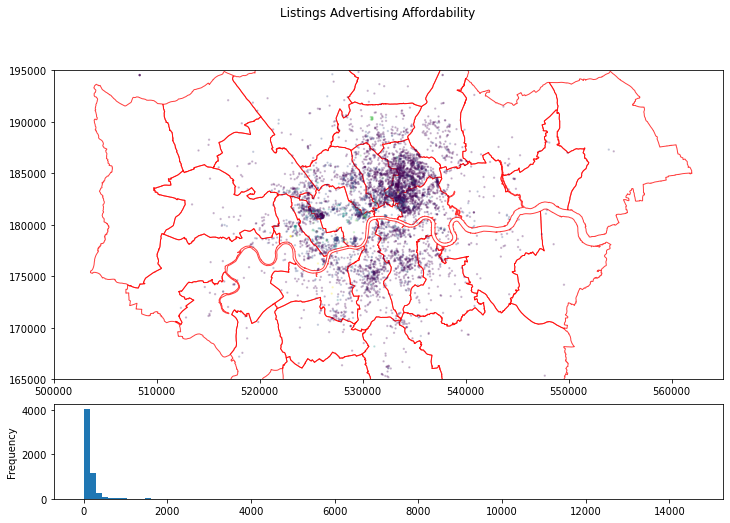

In [74]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Listings Advertising Affordability")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Working on Word Clouds
**this code was part of the process of writing the code but is not essential to the analysis**

**this comes directly from practical 7 and I need to adjust/work through it better.** For this, I will need to tokenise using ngrams which will give information on the frequency. I will use trigrams because it will better capture the context of words.

In [64]:
#establishing the corpus for the word clouds and further NLP
corpus = gent1.description_norm.fillna(' ').values
print(corpus[0:3])

['recently renovate flat locate central london  walk distance tube station . liverpool street street  zone  main london site attraction . well overground station . hoxton shoreditch high street . space flat locate central london  walk distance tube station . liverpool street street  zone  main london site attraction . well overground station . hoxton shoreditch high street . great connection stratford  olympic game take place  canary wharf.the area around  call shoreditch  lively vibrant  hearth city  namely financial centre  time cultural event take place every day.the famous brick lane  columbia road hoxton square round corner  flat recently renovate fully'
 'situate heart vibrant clerkenwell  many consider creative culinary capital london within short walk multitude  restaurant . self contain accommodation door  feature comfort convenience hotel easy access keypad suite wifi upgrade brand renovation apartment ensuite bathroom loungekitchenette space luxurious self contain bedroom su

In [65]:
#tokenise and ngrams
fcounts = dict()

#this tells you the frequency of uni, bi, and tri grams in the corpus
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 4878 samples and 73588 outcomes>
<FreqDist with 38662 samples and 73587 outcomes>
<FreqDist with 61859 samples and 73586 outcomes>


In [66]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

         Ngram Size 1
london           1494
space            1317
flat             1287
room             1201
bedroom          1094
walk              875
access            811
double            751
kitchen           750
minute            713

                    Ngram Size 2
guest     access             409
minute    walk               348
central   london             321
double    bedroom            298
living    room               293
east      london             198
transport link               172
walk      distance           154
open      plan               152
fully     equip              142

                              Ngram Size 3
fully     equip     kitchen             68
guest     access    guest               59
within    walk      distance            55
great     transport link                52
guest     access    access              47
open      plan      kitchen             42
minute    walk      away                41
excellent transport link                40
guest 

In [67]:
#Fit the corpus; turning ngrams into v
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3))

In [68]:
#Transform the corpus
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus

<1000x102674 sparse matrix of type '<class 'numpy.int64'>'
	with 199733 stored elements in Compressed Sparse Row format>

In [69]:
#Filter out low frequency words
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:5,0:10]

Raw count vectorised data frame has 1,000 rows and 102,674 columns.


,aand,aand comfy,aand comfy sofa,abbey,abbey road,abbey road innumerable,abbeytate,abbeytate britv,abbeytate britv asci,able
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [70]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 102,674 terms in the data set.


aand               1
aand comfy         1
aand comfy sofa    1
abbey              1
abbey road         1
dtype: int64

In [71]:
filter_terms = sums >= cvdf.shape[0] * 0.01

In [72]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:5,0:10]

Filtered count vectorised data frame has 1,000 rows and 1,778 columns.


,able,able access,access,access access,access bathroom,access bedroom,access central,access central london,access entire,access entire flat
0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [73]:
#TD-IDF Vectoriser
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01)
tftcorpus = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

In [74]:
# transformed TF-IDF Corpus
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 1,000 rows and 1,682 columns.


,able,able access,access,access access,access bathroom,access bedroom,access central,access central london,access entire,access entire flat,...,wooden,wooden floor,wooden floor throughout,work,world,would,yard,year,young,zone
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13
1,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.08,0.09,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.08
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


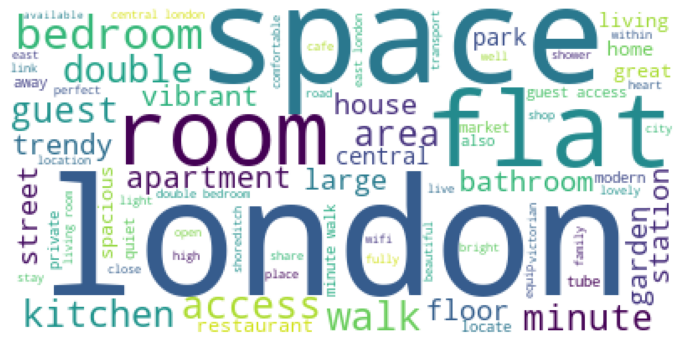

In [75]:
#MAKING THE WORD CLOUD
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(fcvdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

### Topic Modelling - Latent Dirchlet Allocation
**this code was part of the process of writing the code but is not essential to the analysis**

In [76]:
#set the vectoriser
vectorizer = CountVectorizer(ngram_range=(1,2))

In [77]:
#calculate the topics
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(n_components=3, random_state=42)

In [78]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(1000, 3)

In [79]:
pd.options.display.max_colwidth=20
gent1['Topic'] = topic_values.argmax(axis=1)
gent1.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry,description_norm,Topic
2,284532,COSY STUDIO-FLAT...,my very recently...,1481412,"London, United K...",1,3,Tower Hamlets,51.53,-0.07,Entire rental unit,Entire home/apt,90.00,5,365,POINT (-0.07426 ...,recently renovat...,1
5,107048,A Luxury Studio ...,situated in the ...,259088,United Kingdom,5,12,Islington,51.52,-0.10,Private room in ...,Private room,180.00,4,365,POINT (-0.10484 ...,situate heart vi...,0
12,117203,A stylish origin...,a very large and...,255103,"London, United K...",1,1,Hammersmith and ...,51.50,-0.23,Entire rental unit,Entire home/apt,136.00,5,90,POINT (-0.23300 ...,large light bedr...,1
28,142117,Stylish & Bright...,"newly decorated,...",192627,"London, United K...",2,2,Hackney,51.53,-0.09,Entire rental unit,Entire home/apt,180.00,3,1125,POINT (-0.08985 ...,newly decorate ...,1
35,143478,"Large room, Lond...",lovely bright do...,696065,"London, United K...",7,8,Hackney,51.54,-0.05,Private room in ...,Private room,35.00,1,730,POINT (-0.05457 ...,lovely bright do...,1


In [80]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(gent1[gent1.Topic==1].description.values) # tcorpus for transformed corpus

In [81]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names_out())

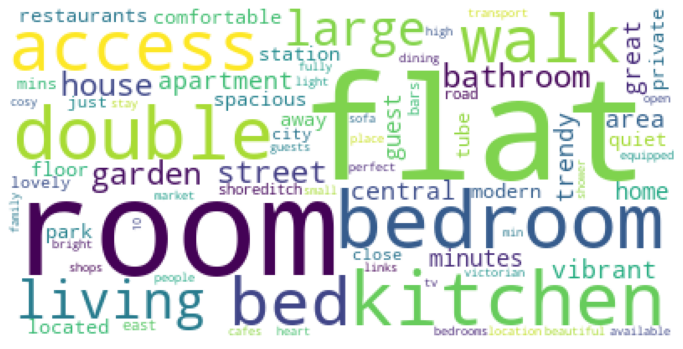

In [82]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

### Topic Modelling for Target Boroughs
The aim of this section is to identify the rhetoric used on Airbnb to describe listings in these boroughs. It will provide insight into how people decide to market listings in specific areas. In other words, what societal discourses do hosts tap into and view as profitable?

In [75]:
%load_ext autoreload
%autoreload 2
from textual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#normalise borough descriptions
Haringey['description_norm'] = Haringey.description.apply(normalise_document, remove_digits=True)
kc['description_norm'] = kc.description.apply(normalise_document, remove_digits=True)
Camden['description_norm'] = Camden.description.apply(normalise_document, remove_digits=True)
Sutton['description_norm'] = Sutton.description.apply(normalise_document, remove_digits=True)
Merton['description_norm'] = Merton.description.apply(normalise_document, remove_digits=True)

In [ ]:
corpus_haringey = Haringey.description_norm.fillna(' ').values
corpuskc = kc.description_norm.fillna(' ').values
corpus_camden = Camden.description_norm.fillna(' ').values
corpus_sutton = Sutton.description_norm.fillna(' ').values
corpus_merton = Merton.description_norm.fillna(' ').values

In [ ]:
#set the initial vectoriser to calculate the topics
vectorizer = CountVectorizer(ngram_range=(1,2))

In [ ]:
LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too

In [ ]:
#calculate the topics: Haringey
vectorizer.fit(corpus_haringey) 
tcorpus_haringey = vectorizer.transform(corpus_haringey) # tcorpus for transformed corpus

LDA.fit(tcorpus_haringey)

In [ ]:
#calculate the topics: Kensington and Chelsea
vectorizer.fit(corpuskc) 
tcorpus_kc = vectorizer.transform(corpuskc) # tcorpus for transformed corpus

In [ ]:
LDA.fit(tcorpus_kc)

In [ ]:
#calculate the topics: Camden
vectorizer.fit(corpus_camden) 
tcorpus_camden = vectorizer.transform(corpus_camden) # tcorpus for transformed corpus

In [ ]:
LDA.fit(tcorpus_camden)

In [ ]:
#calculate the topics: Sutton
vectorizer.fit(corpus_sutton) 
tcorpus_sutton = vectorizer.transform(corpus_sutton) # tcorpus for transformed corpus

In [ ]:
LDA.fit(tcorpus_sutton)

In [ ]:
#calculate the topics: Merton
vectorizer.fit(corpus_merton) 
tcorpus_merton = vectorizer.transform(corpus_sutton) # tcorpus for transformed corpus

In [ ]:
LDA.fit(tcorpus_merton)

In [ ]:
#Maximum Likelihood Topics
topic_values_haringey = LDA.transform(tcorpus_haringey)
topic_values_kc = LDA.transform(tcorpus_kc)
topic_values_camden = LDA.transform(tcorpus_camden)
topic_values_sutton = LDA.transform(tcorpus_sutton)
topic_values_merton = LDA.transform(tcorpus_merton)

In [ ]:
Haringey['Topic'] = topic_values_haringey.argmax(axis=1)
kc['Topic'] = topic_values_kc.argmax(axis=1)
Camden['Topic'] = topic_values_camden.argmax(axis=1)
Sutton['Topic'] = topic_values_sutton.argmax(axis=1)
Merton['Topic'] = topic_values_merton.argmax(axis=1)

In [ ]:
#set the vectoriser again for the topic modelling df
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)

In [ ]:
#create the topic corpuses for the transformed corpuses
topic_corpus_haringey = vectorizer.fit_transform(Haringey[Haringey.Topic==1].description.values)
topic_corpus_kc = vectorizer.fit_transform(kc[kc.Topic==1].description.values)
topic_corpus_camden = vectorizer.fit_transform(Camden[Camden.Topic==1].description.values)
topic_corpus_sutton = vectorizer.fit_transform(Sutton[Sutton.Topic==1].description.values)
topic_corpus_merton = vectorizer.fit_transform(Merton[Merton.Topic==1].description.values)

In [ ]:
#make df of the new topics for each borough!
topicdf_harigey = pd.DataFrame(data=topic_corpus_haringey.toarray(), columns=vectorizer.get_feature_names_out())
topicdf_kc = pd.DataFrame(data=topic_corpus_kc.toarray(), columns=vectorizer.get_feature_names_out())
topicdf_camden = pd.DataFrame(data=topic_corpus_camden.toarray(), columns=vectorizer.get_feature_names_out())
topicdf_sutton = pd.DataFrame(data=topic_corpus_sutton.toarray(), columns=vectorizer.get_feature_names_out())
topicdf_merton = pd.DataFrame(data=topic_corpus_merton.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
#Make the word cloud: Haringey
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf_haringey.sum())
plt.imshow(Cloud) 
plt.axis("off");

In [52]:
#Make the word cloud: Kensington and Chelsea
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf_kc.sum())
plt.imshow(Cloud) 
plt.axis("off");

NameError: name 'topicdf_kc' is not defined

<Figure size 864x864 with 0 Axes>

In [ ]:
#Make the word cloud: Camden
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf_camden.sum())
plt.imshow(Cloud) 
plt.axis("off");

In [ ]:
#Make the word cloud: Sutton
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf_sutton.sum())
plt.imshow(Cloud) 
plt.axis("off");

In [ ]:
#Make the word cloud: Merton
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf_merton.sum())
plt.imshow(Cloud) 
plt.axis("off");